In [1]:
import os
import pickle

import scipy.io as sio
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.utils as tutils
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as tv_transforms
import torchvision.utils as vutils
import torchvision.datasets as tv_datasets
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.decomposition import PCA

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda:0


# PCA with CUB and AWA2 

In [2]:
matcontent = sio.loadmat("data/CUB/res101.mat")
feas = matcontent["features"].T
labels = matcontent['labels'].astype(int).squeeze() - 1

matcontent = sio.loadmat("data/CUB/att_splits.mat")
test_seen_loc = matcontent['test_seen_loc'].squeeze() - 1
test_unseen_loc = matcontent['test_unseen_loc'].squeeze() - 1
trainval_loc = matcontent['trainval_loc'].squeeze() - 1

In [3]:
perm_idx = np.random.permutation(np.arange(test_unseen_loc.shape[0]))
train_idx = perm_idx[:int(test_unseen_loc.shape[0]*0.8)]
test_idx = perm_idx[int(test_unseen_loc.shape[0]*0.8):]

In [4]:
add_train_y = labels[test_unseen_loc[train_idx]]
add_train_x = feas[test_unseen_loc[train_idx]]
add_test_y = labels[test_unseen_loc[test_idx]]
add_test_x = feas[test_unseen_loc[test_idx]]

train_feas = np.concatenate([feas[trainval_loc], add_train_x], axis=0)
train_y = np.concatenate([labels[trainval_loc], add_train_y])
test_feas = np.concatenate([feas[test_seen_loc], add_test_x], axis=0)
test_y = np.concatenate([labels[test_seen_loc], add_test_y])

In [5]:
torch.save({"train_x": torch.from_numpy(train_feas).float(),
            "train_y": torch.from_numpy(train_y).long(),
            "test_x": torch.from_numpy(test_feas).float(),
            "test_y": torch.from_numpy(test_y).long()}, 
            f"data/CUB/train-test-split.tar")

In [7]:
train_y.shape

(9430,)

In [27]:
# scaler = preprocessing.MinMaxScaler()
# train_feature = scaler.fit_transform(feas[trainval_loc])
# test_seen_feature = scaler.transform(feas[test_seen_loc])
# test_unseen_feature = scaler.transform(feas[test_unseen_loc])
train_feature = feas[trainval_loc]
test_seen_feature = feas[test_seen_loc]
test_unseen_feature = feas[test_unseen_loc]
mx = train_feature.max()
train_feature = train_feature/mx
test_seen_feature = test_seen_feature/mx
test_unseen_feature = test_unseen_feature/mx

test_seen_label = torch.from_numpy(labels[test_seen_loc]).long()
test_unseen_label = torch.from_numpy(labels[test_unseen_loc]).long()
train_label = torch.from_numpy(labels[trainval_loc]).long()

In [28]:
num_comp = 100
pca_fcn = PCA(n_components=num_comp).fit(train_feature)
train_pca = pca_fcn.transform(train_feature)
test_seen_pca = pca_fcn.transform(test_seen_feature)
test_unseen_pca = pca_fcn.transform(test_unseen_feature)

train_pca = torch.from_numpy(train_pca).float()
test_seen_pca = torch.from_numpy(test_seen_pca).float()
test_unseen_pca = torch.from_numpy(test_unseen_pca).float()

In [29]:
torch.save({"train_feas": train_pca,
            "test_seen_feas": test_seen_pca,
            "test_unseen_feas": test_unseen_pca,
            "test_seen_label": test_seen_label,
            "test_unseen_label": test_unseen_label,
            "train_label": train_label}, 
            f"data/CUB/pca{num_comp}.tar")

In [ ]:
# train_feas = torch.from_numpy(feas[trainval_loc])
# mem_size = train_feas.element_size() * train_feas.nelement()
# print(mem_size*1e-6)
atensor = torch.randn(1, 224, 224, 3)
img_mem_size = atensor.element_size()*atensor.nelement()
atensor = torch.randn(1, 2048)
feas_mem_size = atensor.element_size()*atensor.nelement()

(img_mem_size*2000*1e-6)

# Util for CORe50

In [ ]:
from dataset import CORE50
import torch.utils.data as data


class CustomTensorDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor, transform=None):
        self.tensors = (x_tensor, y_tensor)
        self.transform = transform
        self.length = x_tensor.shape[0]

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.length


class LogitAppend(data.Dataset):
    """
    Use this only on training data
    """
    def __init__(self, dataset, y_tensor, name, remap=True):
        super(LogitAppend, self).__init__()
        self.dataset = dataset
        self.name = name
        self.number_classes = len(torch.unique(y_tensor))
        class_list = torch.unique(y_tensor).numpy()
        self.labels = torch.LongTensor(y_tensor)  # It will be used as tensor in loader generators.

        self.remap = remap
        if remap:
            self.class_mapping = {c: i for i, c in enumerate(class_list)}

        self.logits = [[] for _ in range(y_tensor.size(0))]

    def __len__(self):
        return len(self.logits)

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        label = self.labels[index]
        if self.remap:
            raw_target = label.item() if isinstance(label, torch.Tensor) else label
            label = torch.tensor(self.class_mapping[raw_target])
        logits = self.logits[index]
        return img, label, logits
            

# Initialize Pre-trained Feature Extractor

In [2]:
import torchvision.models as models

model = models.resnet50(pretrained=False)
model.fc = nn.Identity()
# model.maxpool = nn.Identity()
# model.avgpool = nn.Identity()
model = model.to(device)

In [ ]:
import torchvision.models as models
model = models.vgg16(pretrained=True)
# model.fc = nn.Identity()
# model.maxpool = nn.Identity()
# model.avgpool = nn.Identity()
model = model.to(device)

# One-Time Feature Extraction

Core50 data, competition setup

In [ ]:
dataset = CORE50("data/core50/data", True, scenario='multi-task-nc')
img_trans = tv_transforms.Compose([
                                   tv_transforms.ToPILImage(),
                                   tv_transforms.Resize(224),
                                   tv_transforms.ToTensor(),
                                   tv_transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])


model.eval()
for ii, (x_ds,y_ds,_) in enumerate(dataset):
    print(f"Task {ii+1}")
    x_ds = torch.from_numpy(x_ds).permute(0,3,1,2)
    y_ds = torch.from_numpy(y_ds)
    ds = CustomTensorDataset(x_ds, y_ds, img_trans)
    dataloader = data.DataLoader(ds, batch_size=32, shuffle=False, 
                            num_workers=4)
    feats = []
    labels = []
    with torch.no_grad():
        for x_mb, y_mb in dataloader:
            x_mb = x_mb.to(device)
            feas = model(x_mb)
            feats.append(feas)
            labels.append(y_mb)
    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels)
    print(f"feat size: {feats.size()}")
    print(f"label size: {labels.size()}")
    torch.save({"x_train": feats.cpu(),
                "y_train": labels}, f"data/core50feas_task{ii}.tar")

In [ ]:
dataset = CORE50("data/core50/data", True, scenario='multi-task-nc')
validset = dataset.get_full_valid_set()
for (x_ds,y_ds), ii in validset:
    print(f"Task {ii+1}")
    x_ds = torch.from_numpy(x_ds).permute(0,3,1,2)
    y_ds = torch.from_numpy(y_ds)
    ds = CustomTensorDataset(x_ds, y_ds, img_trans)
    dataloader = data.DataLoader(ds, batch_size=32, shuffle=False, 
                            num_workers=4)
    feats = []
    labels = []
    with torch.no_grad():
        for x_mb, y_mb in dataloader:
            x_mb = x_mb.to(device)
            feas = model(x_mb)
            feats.append(feas)
            labels.append(y_mb)
    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels)
    print(f"feat size: {feats.size()}")
    print(f"label size: {labels.size()}")
    torch.save({"x_valid": feats.cpu(),
                "y_valid": labels}, f"data/core50feas_test_task{ii}.tar")

# One-Time Feature Extraction

For CIFAR10/100.

NOT Using Resnet56 from, https://github.com/akamaster/pytorch_resnet_cifar10

In [3]:
img_trans = tv_transforms.Compose([
#                                    tv_transforms.ToPILImage(),
                                   tv_transforms.Resize(224),
                                   tv_transforms.ToTensor(),
                                   tv_transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])


In [4]:
mb_size = 128
model.eval()
train_feas = []
train_labels = []
cifar100 = tv_datasets.CIFAR10("data", train=True, transform=img_trans, download=True)
dataloader = DataLoader(cifar100, batch_size=mb_size, num_workers=4)
with torch.no_grad():
    for x_mb, y_mb in dataloader:
        feas_out = model(x_mb.to(device))
#         feas_out = model.avgpool(model.features(x_mb.to(device)))
#         feas_out = model.classifier[0](feas_out.view(x_mb.size(0),-1))
        train_labels.append(y_mb.numpy())
        train_feas.append(feas_out.view(x_mb.size(0),-1).detach())

    train_feas = torch.cat(train_feas, dim=0)
    y_train = np.concatenate(train_labels)
    
test_feas = []
test_labels = []
cifar100 = tv_datasets.CIFAR10("data", train=False, transform=img_trans, download=True)
dataloader = DataLoader(cifar100, batch_size=mb_size, num_workers=4)
with torch.no_grad():
    for x_mb, y_mb in dataloader:
        feas_out = model(x_mb.to(device))
#         feas_out = model.avgpool(model.features(x_mb.to(device)))
#         feas_out = model.classifier[0](feas_out.view(x_mb.size(0),-1))
        test_labels.append(y_mb.numpy())
        test_feas.append(feas_out.view(x_mb.size(0),-1).detach())

    test_feas = torch.cat(test_feas, dim=0)
    y_valid = np.concatenate(test_labels)
    
print(f"train_feas: {train_feas.size()}")
print(f"train_labels: {y_train.shape}")
print(f"test_feas: {test_feas.size()}")
print(f"test_label: {y_valid.shape}")

Files already downloaded and verified
Files already downloaded and verified
train_feas: torch.Size([50000, 2048])
train_labels: (50000,)
test_feas: torch.Size([10000, 2048])
test_label: (10000,)


In [5]:
torch.save({"x_train": train_feas.cpu().detach(),
            "x_valid": test_feas.cpu().detach(),
            "y_train": torch.from_numpy(y_train).long(),
            "y_valid": torch.from_numpy(y_valid).long()}, 
#            "data/cifar-100-python/res18_feas_resized_prepool.tar")
           "data/cifar-10-batches-py/res50_feas_randinit.tar")

# Load Extracted Features

In [ ]:
checkpoint = torch.load("data/cifar-10-batches-py/res50_feas_resized.tar")
# checkpoint = torch.load("data/cifar-100-python/res50_feas_resized.tar")
x_train = checkpoint["x_train"].numpy()
x_valid = checkpoint["x_valid"].numpy()

y_train = checkpoint['y_train']
y_valid = checkpoint["y_valid"]

scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_train = torch.from_numpy(x_train)
x_valid = torch.from_numpy(x_valid)

# Train Upper Bound Classifier

In [ ]:
from gen_model import LinearCLS

mb_size = 128
linear_cls = LinearCLS(x_train.size(1), 100).to(device)
optimizer_cls = torch.optim.Adam(linear_cls.parameters(), lr=0.001, betas=(0.5, 0.999))
cls_criterion = nn.NLLLoss()

num_iter = x_train.size(0) // mb_size
bd_indices = [ii for ii in range(0, x_train.size(0), mb_size)]

for epc in range(40):
    batch_indices = np.random.permutation(np.arange(x_train.size(0)))
    for idx, iter_count in enumerate(bd_indices):
        batch_idx = batch_indices[iter_count:iter_count+mb_size]
        x_mb = x_train[batch_idx].float().to(device)
        y_mb = y_train[batch_idx].to(device)
        output = linear_cls(x_mb)
        loss = cls_criterion(output, y_mb)
        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()


In [ ]:
num_iter = x_valid.size(0) // mb_size
bd_indices = [ii for ii in range(0, x_valid.size(0), mb_size)]
batch_indices = np.arange(x_valid.size(0))
corr = 0
with torch.no_grad():
    for idx, iter_count in enumerate(bd_indices):
        batch_idx = batch_indices[iter_count:iter_count+mb_size]
        x_mb = x_valid[batch_idx].float().to(device)
        y_mb = y_valid[batch_idx].to(device)
        output = linear_cls(x_mb)
        pred = torch.argmax(output,dim=1)
        corr += torch.sum(torch.eq(y_mb, pred))

acc = 100*corr / float(x_valid.size(0))
print(f"accuracy: {acc}")

# Visualization

In [ ]:
from sklearn.manifold import TSNE


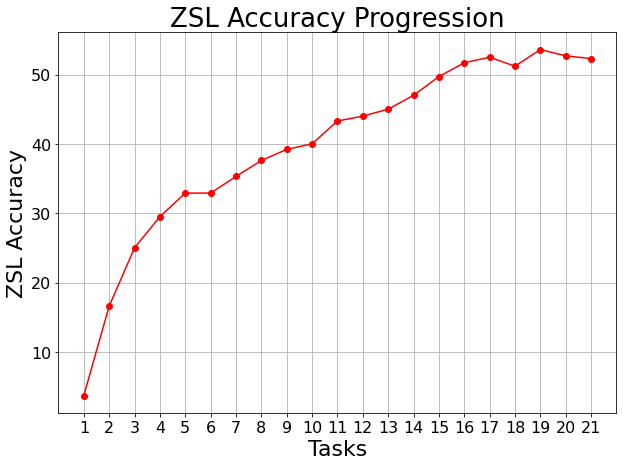

In [3]:
zsl_arr = np.array([3.7, 16.6, 25.0, 29.5, 32.9, 32.9, 35.3, 37.6, 39.2,
                    40.0, 43.3, 44.0, 45.0, 47.0, 49.7, 51.7, 52.5, 51.2,
                    53.6, 52.7, 52.3])
plt.figure(figsize=(10,7))
plt.plot(zsl_arr, '-ro')
plt.xlabel("Tasks", fontsize=22)
plt.xticks(ticks=np.arange(len(zsl_arr)),labels=np.arange(1,len(zsl_arr)+1), fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("ZSL Accuracy", fontsize=22)
plt.grid(True)
plt.title("ZSL Accuracy Progression", fontsize=26)
plt.savefig("zsl_prog.png",bbox_inches='tight')


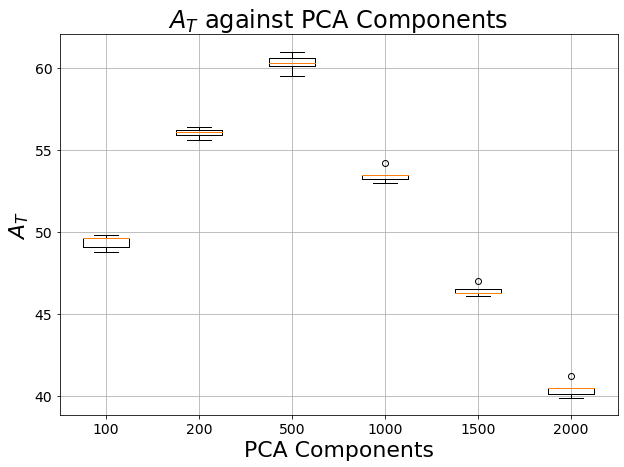

In [71]:
pca100 = np.array([49.6, 49.1, 49.8, 48.8, 49.6])
pca200 = np.array([56.1, 55.6, 55.9, 56.4, 56.2])
pca500 = np.array([60.1, 61.0, 60.6, 59.5, 60.3])
pca1000 = np.array([53.5, 53.0, 53.2, 53.5, 54.2])
pca1500 = np.array([46.3, 47.0, 46.5, 46.1, 46.3])
pca2000 = np.array([40.5, 39.9, 40.1, 41.2, 40.5])
pca_count = np.array([100, 200, 500, 1000, 1500, 2000])
plt.figure(figsize=(10,7))
# plt.bar([1,2,3,4,5,6], pca_arr)
plt.boxplot([pca100, pca200, pca500, pca1000, pca1500, pca2000])

plt.xticks([1,2,3,4,5,6], labels=pca_count, fontsize=14)
plt.xlabel("PCA Components", fontsize=22)
plt.ylabel(r"$A_T$", fontsize=22)
plt.yticks(fontsize=14)
plt.title(r"$A_T$ against PCA Components", fontsize=24)
plt.grid(True)
# plt.show()
plt.savefig("feas-dim.png",bbox_inches='tight')